# 1. Overall density profile of a given year
### To be in accordance with TEOS-10 it translates from Salinity_[psu] & Temp_[°C] into Absolute_Salinity [g/kg] & Conservative_Temp_deg [°C]


/tmp/ipykernel_22362/2263569714.py:114: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


Loaded ArcticOcean_phys_oce_1980.txt with 282231 levels

Profile overview:
                        source_file  Prof_no          Cruise Station Platform  \
0     ArcticOcean_phys_oce_1980.txt      490       G.O._SARS    0158        S   
1     ArcticOcean_phys_oce_1980.txt      491       G.O._SARS    0059        S   
2     ArcticOcean_phys_oce_1980.txt      492    OTTO_SCHMIDT    0575        S   
3     ArcticOcean_phys_oce_1980.txt      493    MICHAEL_SARS    0198        S   
4     ArcticOcean_phys_oce_1980.txt      494    MICHAEL_SARS    0215        S   
...                             ...      ...             ...     ...      ...   
6560  ArcticOcean_phys_oce_1980.txt   183399  ANTON_DOHRN_II     NaN        S   
6561  ArcticOcean_phys_oce_1980.txt   183610  ANTON_DOHRN_II     NaN        S   
6562  ArcticOcean_phys_oce_1980.txt   183608  ANTON_DOHRN_II     NaN        S   
6563  ArcticOcean_phys_oce_1980.txt   183602  ANTON_DOHRN_II     NaN        S   
6564  ArcticOcean_phys_oce_1980.tx

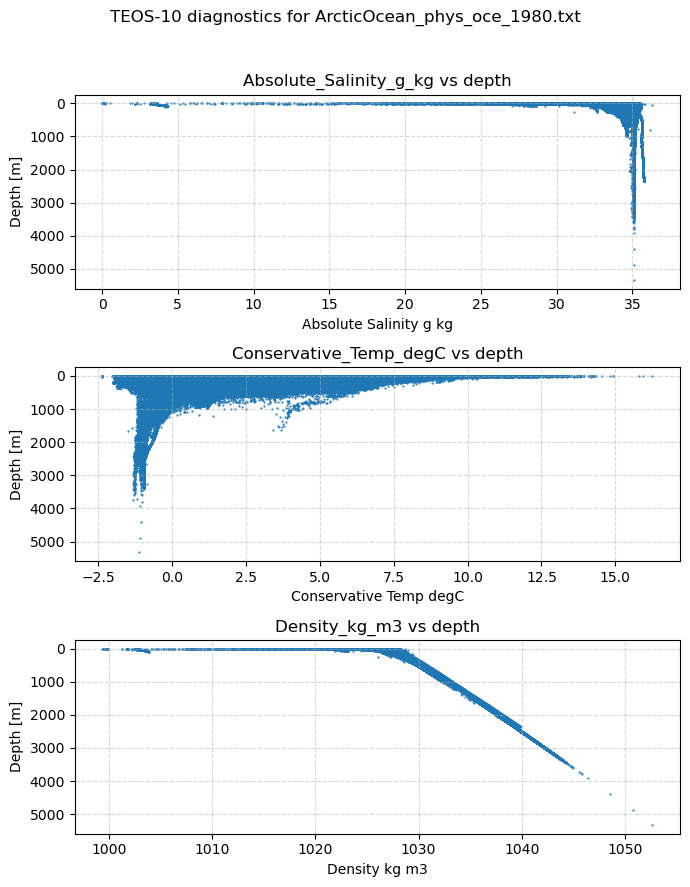

In [19]:
from __future__ import annotations
from dataclasses import dataclass
from pathlib import Path
from typing import Iterable, Optional, Sequence
import numpy as np
import pandas as pd
import gsw
import matplotlib.pyplot as plt

# Warn when raw measurements look suspicious
import warnings

# Directory
PROFILE_TEXT_FILE = Path("UDASH/ArcticOcean_phys_oce_1980.txt")
DEFAULT_UDASH_FILE = PROFILE_TEXT_FILE

# List pertaining names so a notebook can `from udash_density import ...
__all__ = [
    "UDASH_COLUMNS",
    "UDASHProfileMetadata",
    "PROFILE_TEXT_FILE",
    "DEFAULT_UDASH_FILE",
    "load_udash_file",
    "load_default_profile",
    "iter_profile_metadata",
    "summarize_profiles",
    "preview_profile_metadata",
    "preview_level_samples",
    "plot_teos10_diagnostics",
    "save_teos10_variables",
]

# List every column name once for reference
UDASH_COLUMNS = {
    "profile": "Prof_no",
    "cruise": "Cruise",
    "station": "Station",
    "platform": "Platform",
    "instrument_type": "Type",
    "timestamp": "yyyy-mm-ddThh:mm",
    "longitude_deg": "Longitude_[deg]",
    "latitude_deg": "Latitude_[deg]",
    "pressure_dbar": "Pressure_[dbar]",
    "depth_m": "Depth_[m]",
    "temperature_degC": "Temp_[°C]",
    "salinity_psu": "Salinity_[psu]",
    "quality_flag": "QF",
}

@dataclass
class UDASHProfileMetadata:
    """Keep basic profile metadata in an object with attributes"""
    profile: int
    cruise: str
    station: str
    platform: str
    instrument_type: str
    timestamp: str
    longitude_deg: float
    latitude_deg: float

def _infer_profile_year(df: pd.DataFrame) -> str:
    """Grab first timestamp and year for filename"""
    ts_name = UDASH_COLUMNS["timestamp"]
    if ts_name not in df:
        return "unknown"
    timestamps = pd.Series(df[ts_name]).dropna().astype(str)
    if timestamps.empty:
        return "unknown"
    first = timestamps.iloc[0]
    try:
        return str(pd.to_datetime(first).year)
    except (TypeError, ValueError):
        return str(first)[:4]

def save_teos10_variables(
    df: pd.DataFrame,
    *,
    source_path: Path,
    output_root: Path = Path("Density"),
) -> Path:
    """Dump the useful columns into `Density/<year>_file_teos10.txt"""
    year = _infer_profile_year(df)
    output_root.mkdir(parents=True, exist_ok=True)
    output_path = output_root / f"{year}_{source_path.stem}_teos10.txt"

    columns = [
        UDASH_COLUMNS["longitude_deg"],
        UDASH_COLUMNS["latitude_deg"],
        UDASH_COLUMNS["pressure_dbar"],
        UDASH_COLUMNS["depth_m"],
        UDASH_COLUMNS["salinity_psu"],
        UDASH_COLUMNS["temperature_degC"],
        "Absolute_Salinity_g_kg",
        "Conservative_Temp_degC",
        "Density_kg_m3",
        "Potential_Density_kg_m3",
    ]
    present = [name for name in columns if name in df.columns]
    df[present].to_csv(output_path, sep="\t", index=False, float_format="%.6f")
    return output_path

def load_udash_file(
    path: str | Path,
    *,
    missing_value: float = -999.0,
    drop_na: bool = True,
    save_output: bool = True,
    output_root: Path = Path("Density"),
    raise_on_negative_salinity: bool = False,
) -> pd.DataFrame:
    """Read one UDASH file, clean it, run TEOS-10, save it"""
    # Koad the raw text file using pandas for immediate DataFrame
    path = Path(path)
    df = pd.read_csv(
        path,
        delim_whitespace=True,
        na_values=[missing_value],
        engine="python",
    )

    # Strip out rows that are missing any of the key TEOS-10 inputs
    salinity_name = UDASH_COLUMNS["salinity_psu"]
    required = [
        salinity_name,
        UDASH_COLUMNS["temperature_degC"],
        UDASH_COLUMNS["pressure_dbar"],
        UDASH_COLUMNS["longitude_deg"],
        UDASH_COLUMNS["latitude_deg"],
    ]
    if drop_na:
        df = df.dropna(subset=[col for col in required if col in df])

    # Sort by depth (with pressure as a backup)
    sort_keys = [
        key
        for key in (UDASH_COLUMNS["depth_m"], UDASH_COLUMNS["pressure_dbar"])
        if key in df
    ]
    if sort_keys:
        df = df.sort_values(sort_keys).reset_index(drop=True)

    # Convert the relevant columns into NumPy arrays for gsw
    SP = df[salinity_name].to_numpy(float)
    p = df[UDASH_COLUMNS["pressure_dbar"]].to_numpy(float)
    lon = df[UDASH_COLUMNS["longitude_deg"]].to_numpy(float)
    lat = df[UDASH_COLUMNS["latitude_deg"]].to_numpy(float)
    t = df[UDASH_COLUMNS["temperature_degC"]].to_numpy(float)

    # Changes faulty values to NaN
    # Latitude [-90, 90]
    if (lat < -90).any() or (lat > 90).any():
        warnings.warn("Latitude values outside [-90, 90] found; masking.", RuntimeWarning)
        lat = np.where((lat < -90) | (lat > 90), np.nan, lat)

    # Longitude [-180, 360]
    if (lon < -180).any() or (lon > 360).any():
        warnings.warn("Longitude values outside [-180, 360] found; masking.", RuntimeWarning)
        lon = np.where((lon < -180) | (lon > 360), np.nan, lon)

    # Pressure [0, 12000] dbar (safe ocean range)
    if (p < -5).any() or (p > 12000).any():
        warnings.warn("Pressure values outside [0, 12000] dbar found; masking.", RuntimeWarning)
        p = np.where((p < 0) | (p > 12000), np.nan, p)

    # Practical Salinity [0, 50]
    if (SP < 0).any() or (SP > 50).any():
        warnings.warn("Practical Salinity values outside [0, 50] found; masking.", RuntimeWarning)
        SP = np.where((SP < 0) | (SP > 50), np.nan, SP)

    # In-situ Temperature [-5, 40] °C (covers typical ocean)
    if (t < -5).any() or (t > 40).any():
        warnings.warn("Temperature values outside [-5, 40] °C found; masking.", RuntimeWarning)
        t = np.where((t < -5) | (t > 40), np.nan, t)

    # Run the TEOS-10 conversions: Absolute Salinity, Conservative Temperature, density
    SA = gsw.SA_from_SP(SP, p, lon, lat)
    CT = gsw.CT_from_t(SA, t, p)
    rho = gsw.rho(SA, CT, p)
    sigma0 = gsw.sigma0(SA, CT) + 1000.0  # I use potential density referenced to the surface.

    # Attach the new columns
    df = df.copy()
    df.insert(0, "source_file", path.name)
    df["Absolute_Salinity_g_kg"] = SA
    df["Conservative_Temp_degC"] = CT
    df["Density_kg_m3"] = rho
    df["Potential_Density_kg_m3"] = sigma0

    # (no negative_rows anymore) – record lightweight QC info and a validity flag
    df.attrs["qc_counts"] = {
        "latitude_masked": int(np.isnan(lat).sum()),
        "longitude_masked": int(np.isnan(lon).sum()),
        "pressure_masked": int(np.isnan(p).sum()),
        "salinity_masked": int(np.isnan(SP).sum()),
        "temperature_masked": int(np.isnan(t).sum()),
    }
    df["valid_for_teos10"] = (
        np.isfinite(SP) & np.isfinite(t) & np.isfinite(p) & np.isfinite(lon) & np.isfinite(lat)
    )

    # Save the processed columns for reusage in other scripts
    if save_output:
        output_path = save_teos10_variables(df, source_path=path, output_root=output_root)
        df.attrs["teos10_output_path"] = str(output_path)

    return df
    
# Now it´s working towards plotting and printing the data
# Courtesy to ChatGPT
def load_default_profile(
    *,
    missing_value: float = -999.0,
    drop_na: bool = True,
    save_output: bool = True,
    output_root: Path = Path("Density"),
    raise_on_negative_salinity: bool = False,
) -> pd.DataFrame:
    """Call :func:load_udash_file with the profile path set above"""
    return load_udash_file(
        PROFILE_TEXT_FILE,
        missing_value=missing_value,
        drop_na=drop_na,
        save_output=save_output,
        output_root=output_root,
        raise_on_negative_salinity=raise_on_negative_salinity,
    )
# Courtesy to ChatGPT
def preview_profile_metadata(df: pd.DataFrame, *, max_rows: Optional[int] = 10) -> pd.DataFrame:
    """ChatGPT: List the distinct profile metadata rows for a quick sanity check."""
    columns = [
        "source_file",
        UDASH_COLUMNS["profile"],
        UDASH_COLUMNS["cruise"],
        UDASH_COLUMNS["station"],
        UDASH_COLUMNS["platform"],
        UDASH_COLUMNS["instrument_type"],
    ]
    # ChatGPT: Drops duplicates so one profile does not flood the output with all depths.
    preview = df.loc[:, columns].drop_duplicates().reset_index(drop=True)
    if max_rows is not None:
        # Trim the preview unless explicitly asked for every row
        preview = preview.head(max_rows)
    return preview

def preview_level_samples(df: pd.DataFrame, *, samples: int = 12) -> pd.DataFrame:
    """Pick evenly spaced levels"""
    if samples <= 0 or df.empty:
        return df.head(0)
    if samples >= len(df):
        return df
    # Indices between the first and last rows
    idx = np.linspace(0, len(df) - 1, samples)
    # Round and deduplicate the indices before subsetting
    unique_idx = np.unique(idx.round().astype(int))
    return df.iloc[unique_idx]

# Courtesy to ChatGPT
def iter_profile_metadata(df: pd.DataFrame) -> Iterable[UDASHProfileMetadata]:
    """Emit one metadata record per profile to iterate cleanly"""
    seen: set[tuple[int, str]] = set()
    for _, row in df.iterrows():
        key = (int(row[UDASH_COLUMNS["profile"]]), row["source_file"])
        if key in seen:
            continue
        seen.add(key)
        yield UDASHProfileMetadata(
            profile=key[0],
            cruise=str(row[UDASH_COLUMNS["cruise"]]),
            station=str(row[UDASH_COLUMNS["station"]]),
            platform=str(row[UDASH_COLUMNS["platform"]]),
            instrument_type=str(row[UDASH_COLUMNS["instrument_type"]]),
            timestamp=str(row[UDASH_COLUMNS["timestamp"]]),
            longitude_deg=float(row[UDASH_COLUMNS["longitude_deg"]]),
            latitude_deg=float(row[UDASH_COLUMNS["latitude_deg"]]),
        )

def summarize_profiles(df: pd.DataFrame, *, by: Optional[str] = "source_file") -> pd.DataFrame:
    """Summarise each profile with counts and min/max values"""
    group_columns = [by] if by else [UDASH_COLUMNS["profile"], "source_file"]
    summary = (
        df.groupby(group_columns)
        .agg(
            n_levels=(UDASH_COLUMNS["pressure_dbar"], "size"),
            min_pressure=(UDASH_COLUMNS["pressure_dbar"], "min"),
            max_pressure=(UDASH_COLUMNS["pressure_dbar"], "max"),
            min_density=("Density_kg_m3", "min"),
            max_density=("Density_kg_m3", "max"),
        )
        .reset_index()
    )
    return summary

# Actual plotting part
def plot_teos10_diagnostics(
    df: pd.DataFrame,
    *,
    columns: Sequence[str] = (
        "Absolute_Salinity_g_kg",
        "Conservative_Temp_degC",
        "Density_kg_m3",
    ),
    depth_column: str = UDASH_COLUMNS["depth_m"],
    share_depth_axis: bool = True,
    figsize: tuple[float, float] = (7.0, 9.0),
    marker: str = "o",
    marker_size: float = 0.3,
):

    missing = [name for name in columns if name not in df]
    if missing:
        raise KeyError(f"Missing required columns: {', '.join(missing)}")
    if depth_column not in df:
        raise KeyError(f"Depth column '{depth_column}' not found in DataFrame")

    fig, axes = plt.subplots(len(columns), 1, figsize=figsize, sharey=share_depth_axis)
    if len(columns) == 1:
        axes = [axes]

    depth = df[depth_column]
    for ax, name in zip(axes, columns):
        ax.scatter(df[name], depth, s=marker_size, marker=marker)
        ax.set_xlabel(name.replace("_", " "))
        ax.set_ylabel("Depth [m]")
        ax.set_title(f"{name} vs depth")
        ax.invert_yaxis()
        ax.grid(True, linestyle="--", alpha=0.5)

    fig.tight_layout()
    fig.subplots_adjust(top=0.92)
    return fig, axes

if __name__ == "__main__":
    df = load_default_profile()

    file_name = PROFILE_TEXT_FILE.name
    print(f"Loaded {file_name} with {len(df)} levels\n")

    # Show metadata to see which profile the file contains
    print("Profile overview:")
    print(preview_profile_metadata(df, max_rows=None))
    print()

    # Preview representative depth levels without printing the entire table
    print("Sampled profile levels:")
    with pd.option_context("display.max_columns", None, "display.width", None):
        print(preview_level_samples(df, samples=12))
    print()

    # Path
    output_path = df.attrs.get("teos10_output_path")
    if output_path:
        print(f"Saved TEOS-10 variables to: {output_path}\n")

    # Level counts and density ranges.
    print("Density summary:")
    print(
        summarize_profiles(df, by=None)[
            [
                UDASH_COLUMNS["profile"],
                "source_file",
                "n_levels",
                "min_pressure",
                "max_pressure",
                "min_density",
                "max_density",
            ]
        ]
    )


    # 3 scatter plots with tiny dots so individual depths show up
    fig, _ = plot_teos10_diagnostics(df)
    fig.suptitle(f"TEOS-10 diagnostics for {file_name}", y=0.98)
    fig.tight_layout(rect=[0.0, 0.0, 1.0, 0.96])

    # Store in D_figs for convenience
    figs_dir = Path("D_figs")
    figs_dir.mkdir(parents=True, exist_ok=True)
    year = _infer_profile_year(df)
    fig_path = figs_dir / f"{year}_{Path(file_name).stem}_teos10_plots.png"
    fig.savefig(fig_path, dpi=300)
    df.attrs["diagnostic_figure_path"] = str(fig_path)
    print(f"Saved TEOS-10 diagnostic figure to: {fig_path}")

    plt.show()


# 2. Buoyancy Frequency Calculation ###

### We get negative values no matter how

In [8]:
from pathlib import Path
import numpy as np
import pandas as pd
import gsw

# Define columns
COL = {
    "lon": "Longitude_[deg]",
    "lat": "Latitude_[deg]",
    "p":   "Pressure_[dbar]",
    "z":   "Depth_[m]",
    "SA":  "Absolute_Salinity_g_kg",
    "CT":  "Conservative_Temp_degC",
    "rho": "Density_kg_m3",
}

# Fetch variables, checks to keep it in pre-defined realms, sorts variables, removes erronous ones
def _clean_teos10_profile(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df = df.dropna(subset=[COL["SA"], COL["CT"], COL["p"], COL["lat"]])
    df = df.sort_values(COL["p"], kind="mergesort").reset_index(drop=True)
    if df[COL["p"]].duplicated().any():
        df = (df.groupby(COL["p"], as_index=False)
                .agg({COL["SA"]:"mean", COL["CT"]:"mean", COL["lat"]:"mean", COL["z"]:"mean"}))
        df = df.sort_values(COL["p"]).reset_index(drop=True)
    m = (
        np.isfinite(df[COL["SA"]])
        & np.isfinite(df[COL["CT"]])
        & np.isfinite(df[COL["p"]])
        & (df[COL["p"]] > -5)
        & (df[COL["p"]] < 12000)
    )
    df = df[m].reset_index(drop=True)
    if len(df) < 3:
        raise ValueError("Not enough valid levels to compute N² (need ≥3).")
    return df

# Defines computation of Buoyancy Profile and translates variables to float
def compute_N2_QC_from_teosfile(teos_path: Path) -> pd.DataFrame:
    df = pd.read_csv(teos_path, sep=r"\s+|\t", engine="python")
    df = _clean_teos10_profile(df)

    SA  = df[COL["SA"]].to_numpy(float)
    CT  = df[COL["CT"]].to_numpy(float)
    p   = df[COL["p"]].to_numpy(float)
    lat = float(np.nanmean(df[COL["lat"]].to_numpy(float)))

    # TEOS-10 midpoint/adiabatic Nsquared
    N2, p_mid = gsw.Nsquared(SA, CT, p, lat=lat)   # N2 [s^-2], p_mid [dbar]
    z_mid = -gsw.z_from_p(p_mid, lat)              # positive downward [m]

    # Turner angle (already at mid-pressures)
    Tu, Rsubrho, p_mid_Tu = gsw.Turner_Rsubrho(SA, CT, p)
    Tu_mid = Tu  # already midpoints

    # !!!!! MUY IMPORTANTE
    # ChatGPT Suggestion. Might be erronous
    # Handle tiny negatives (likely numerical) but keep truly negative layers flagged
    eps = 1e-10
    N2_raw = N2.copy()
    small_neg = (N2_raw < 0) & (N2_raw > -eps)
    N2_clean = N2_raw.copy()
    N2_clean[small_neg] = 0.0

    # constructrs output fraem
    out = pd.DataFrame({
        "p_mid_dbar": p_mid,
        "z_mid_m": z_mid,
        "N2_s^-2_raw": N2_raw,
        "N2_s^-2": N2_clean,
        "Turner_angle_deg": Tu_mid,
        "flag_negative_raw": (N2_raw < 0).astype(np.int8),
        "flag_small_negative": small_neg.astype(np.int8),
    })
    return out

# Calc common N not N2
def summarize_N2(n2_df: pd.DataFrame) -> pd.DataFrame:
    n2_df = n2_df.copy()
    n2_df["N_s^-1"] = np.sqrt(np.clip(n2_df["N2_s^-2"], 0, None))
    return n2_df[["N2_s^-2", "N_s^-1"]].describe().T

# Yields a neat table
def save_n2_table(n2_df: pd.DataFrame, src_path: Path, out_root: Path = Path("Buoyancy_Freq")) -> Path:
    out_root.mkdir(parents=True, exist_ok=True)
    stem = src_path.stem
    year_prefix = stem.split("_", 1)[0] if "_" in stem else "unknown"
    out_path = out_root / f"{year_prefix}_{stem}_N2.txt"
    n2_df.to_csv(out_path, sep="\t", index=False, float_format="%.10e")
    return out_path



In [9]:
from pathlib import Path
import pandas as pd

# TEOS-10 file produced by your first script
teos10_file = Path("Density") / "1980_ArcticOcean_phys_oce_1980_teos10.txt"  # <-- adjust as needed

# Calls the Calc Fct´s
n2 = compute_N2_QC_from_teosfile(teos10_file)
out_path = save_n2_table(n2, teos10_file)
print(f"Saved N² table to: {out_path}\n")

summary = summarize_N2(n2)
print(summary.to_string(float_format=lambda x: f"{x:12.6f}"))


Saved N² table to: Buoyancy_Freq/1980_1980_ArcticOcean_phys_oce_1980_teos10_N2.txt

               count         mean          std          min          25%          50%          75%          max
N2_s^-2 31941.000000     0.020790     0.450150    -8.988525    -0.019998     0.000497     0.032132    23.703310
N_s^-1  31941.000000     0.121096     0.201708     0.000000     0.000000     0.022297     0.179255     4.868605


In [10]:
from pathlib import Path
import pandas as pd
import numpy as np

# Runs it for all densities to save time
for teos10_file in sorted(Path("Density").glob("*_teos10.txt")):
    try:
        n2 = compute_N2_QC_from_teosfile(teos10_file)
        out_path = save_n2_table(n2, teos10_file)
        print(f"\n=== {teos10_file.name} ===")
        print(f"Saved N² table to: {out_path}")

        summary = summarize_N2(n2)
        print(summary.to_string(float_format=lambda x: f"{x:12.6f}"))

        n_neg = int((n2["flag_negative_raw"] == 1).sum())
        n_small = int((n2["flag_small_negative"] == 1).sum())
        print(f"Negatives (raw): {n_neg} | Tiny-negatives clipped: {n_small}")

    except Exception as e:
        print(f"\n=== {teos10_file.name} ===")
        print(f"Skipped due to error: {e}")



=== 1980_ArcticOcean_phys_oce_1980_teos10.txt ===
Saved N² table to: Buoyancy_Freq/1980_1980_ArcticOcean_phys_oce_1980_teos10_N2.txt
               count         mean          std          min          25%          50%          75%          max
N2_s^-2 31941.000000     0.020790     0.450150    -8.988525    -0.019998     0.000497     0.032132    23.703310
N_s^-1  31941.000000     0.121096     0.201708     0.000000     0.000000     0.022297     0.179255     4.868605
Negatives (raw): 14938 | Tiny-negatives clipped: 0

=== 1981_ArcticOcean_phys_oce_1981_teos10.txt ===
Saved N² table to: Buoyancy_Freq/1981_1981_ArcticOcean_phys_oce_1981_teos10_N2.txt
               count         mean          std          min          25%          50%          75%          max
N2_s^-2 61394.000000     0.006137     0.193396    -5.803879    -0.018042    -0.000246     0.012622    22.690388
N_s^-1  61394.000000     0.082149     0.159546     0.000000     0.000000     0.000000     0.112346     4.763443
Negatives

# 3. Creating the Eigenvalue Problem